# Twitter sentiment analysis
## This paper presents a step-by-step personal tweet analysis process.

For personal analysis of tweets, we need an accurate model for assessing the sentiment of a tweet that is trained on a very large sample.
Dataset for training our model can be downloaded from the below link.
http://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip


In [1]:
import pandas as pd  
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
cols = ['sentiment','id','date','query_string','user','text']

In [3]:
df = pd.read_csv("PycharmProjects/jupyter/training.1600000.processed.noemoticon.csv",header=None,
                                                                names=cols, encoding="ISO-8859-1")


## Initial text data info


In [4]:
df.drop(['id','date','query_string','user'],axis=1,inplace=True)
df.head()

,sentiment,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 2 columns):
sentiment    1600000 non-null int64
text         1600000 non-null object
dtypes: int64(1), object(1)
memory usage: 24.4+ MB


## Cleaned the tweets

In the next step, we cleaned the tweets, which included: removing punctuation, url links and other technical tweet components, tokenization and lematization of the pre-cleared text.


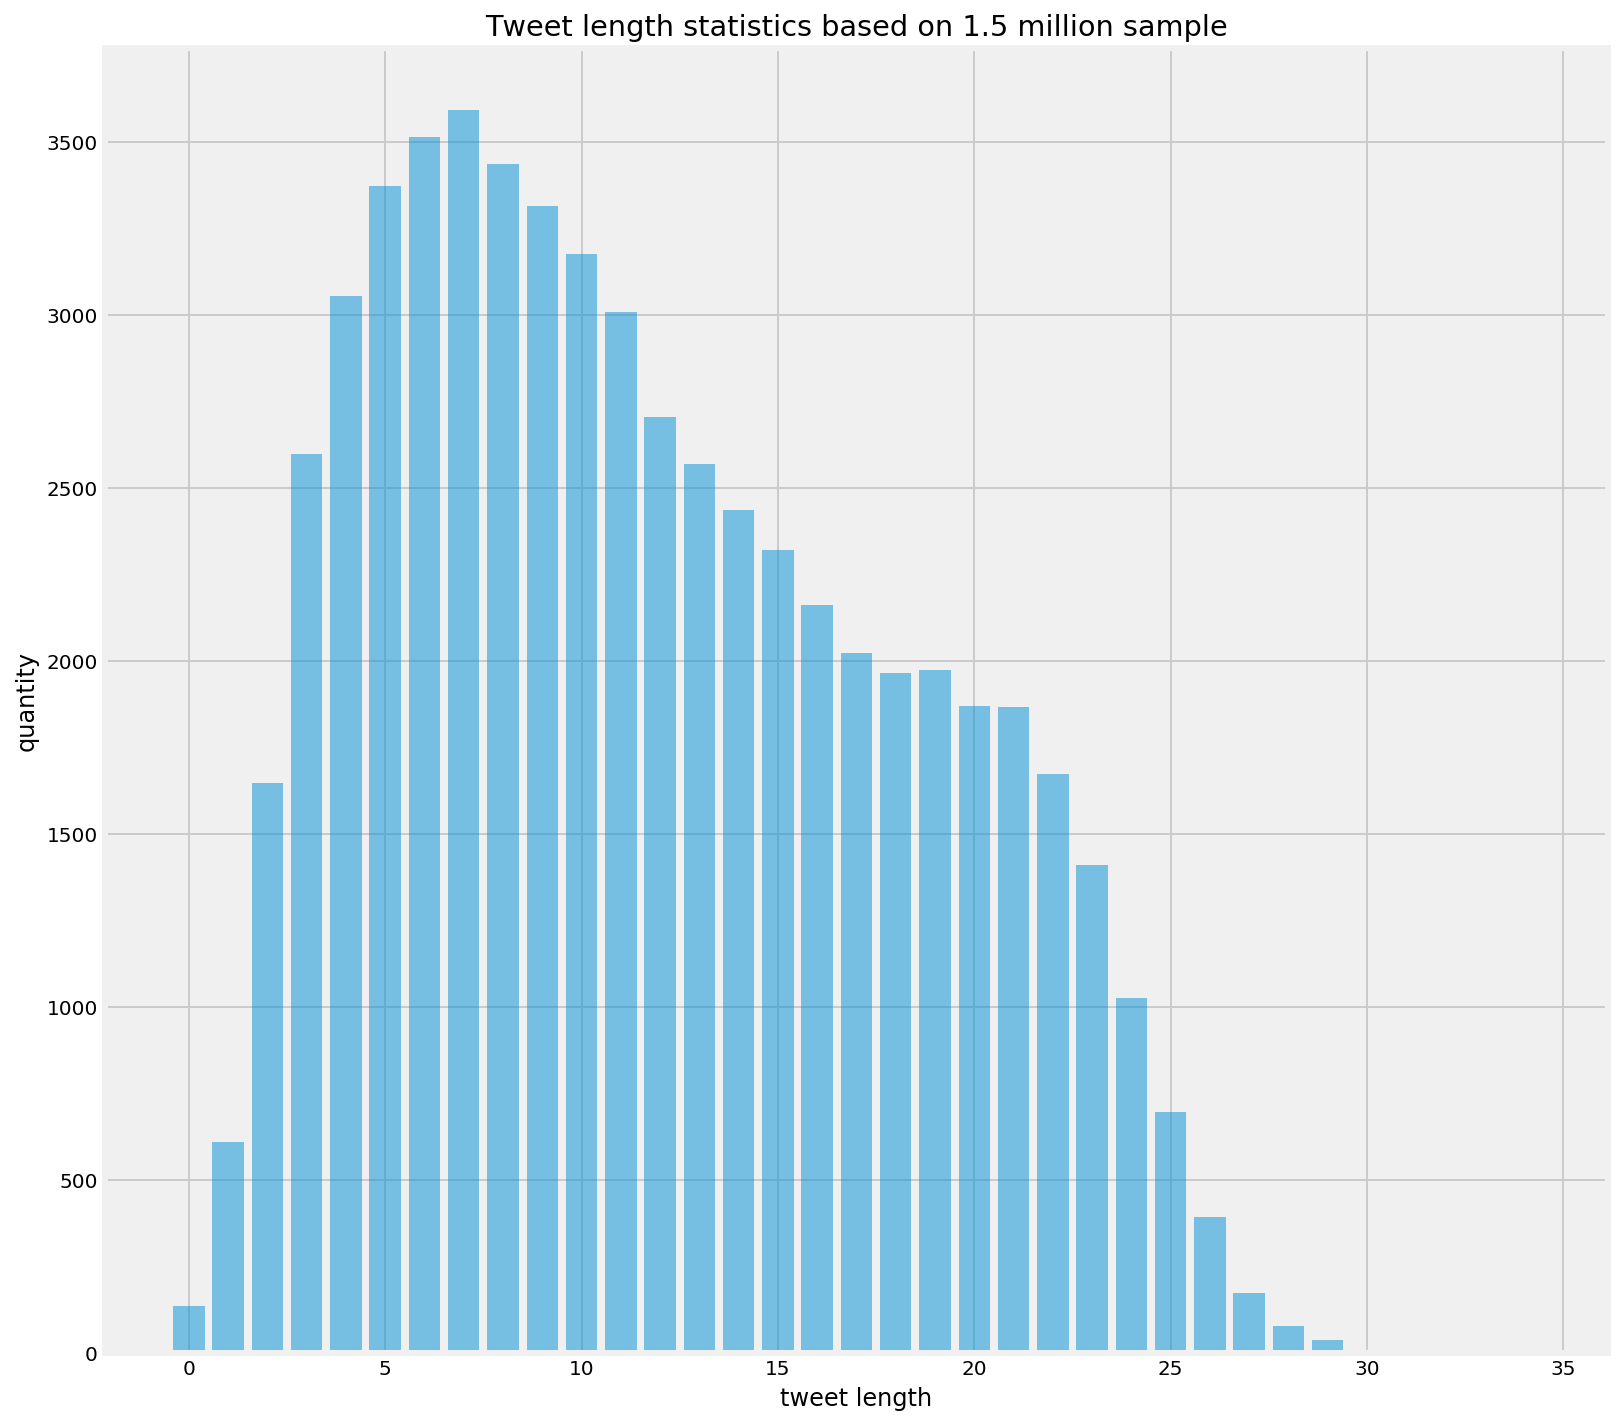

In [6]:
import re
import numpy as np
from bs4 import BeautifulSoup
from nltk.tokenize import WordPunctTokenizer
import pandas as pd
import matplotlib.pyplot as plt
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem import PorterStemmer
from pylab import rcParams
rcParams['figure.figsize'] = 12, 12

# ==============================================================================================================


tweet_len = 5  # ограничение длинны твита
sample_size = 10000  # размер выборки (учесть то, что для выборки размером 100к итоговый сэмпл
no_limit_output_file = 'nolim_test.csv'  # учитывая ограничение длины твита будет более чем в 5 раз меньше)
limit_output_file = 'lim_test.csv'  # выходные csv файлы

# ==============================================================================================================

tok = WordPunctTokenizer()

pat1 = r'@[A-Za-z0-9_]+'
pat2 = r'https?://[^ ]+'
combined_pat = r'|'.join((pat1, pat2))
www_pat = r'www.[^ ]+'
negations_dic = {"isn't": "is not", "aren't": "are not", "wasn't": "was not", "weren't": "were not",
                 "haven't": "have not", "hasn't": "has not", "hadn't": "had not", "won't": "will not",
                 "wouldn't": "would not", "don't": "do not", "doesn't": "does not", "didn't": "did not",
                 "can't": "can not", "couldn't": "could not", "shouldn't": "should not", "mightn't": "might not",
                 "mustn't": "must not"}
neg_pattern = re.compile(r'\b(' + '|'.join(negations_dic.keys()) + r')\b')


def tweet_cleaner_updated(text, tweet_len_list=None, tweet_len=35):
    soup = BeautifulSoup(text, 'lxml')
    souped = soup.get_text()
    try:
        bom_removed = souped.decode("utf-8-sig").replace(u"\ufffd", "?")
    except:
        bom_removed = souped
    stripped = re.sub(combined_pat, '', bom_removed)
    stripped = re.sub(www_pat, '', stripped)
    lower_case = stripped.lower()
    neg_handled = neg_pattern.sub(lambda x: negations_dic[x.group()], lower_case)
    letters_only = re.sub("[^a-zA-Z]", " ", neg_handled)

    # words = [x for x in tok.tokenize(letters_only) if len(x) > 1]
    # stemmer = SnowballStemmer("english")
    stemmer = PorterStemmer()
    lema = WordNetLemmatizer()
    words = list()
    for word in tok.tokenize(letters_only):
        if len(word) > 1:
            word = lema.lemmatize(word)
            # word = stemmer.stem(word))
            words.append(word)

    tweet_len_list.append(int(len(words)))
    if len(words) <= tweet_len:
        return (" ".join(words)).strip()


def train_csv_file_output(tweet_len, sample_size, no_limit_output_file, limit_output_file,
                          input_csv="PycharmProjects/jupyter/training.1600000.processed.noemoticon.csv"):
    cols = ['sentiment', 'id', 'date', 'query_string', 'user', 'text']
    df = pd.read_csv(input_csv, header=None, names=cols, encoding="ISO-8859-1")
    df.drop(['id', 'date', 'query_string', 'user'], axis=1, inplace=True)
    df['sentiment'] = df['sentiment'].map({0: 0, 4: 1})
    df['pre_clean_len'] = [len(t) for t in df.text]

    clean_tweet_texts = []
    target_tweet = []
    tweet_len_list = list()

    for i in range(int(800000 - (sample_size / 2)), int(800000 + (sample_size / 2))):
        clr_tweet = tweet_cleaner_updated(df['text'][i], tweet_len=tweet_len, tweet_len_list=tweet_len_list)
        if clr_tweet is not None:
            clean_tweet_texts.append(clr_tweet)
            target_tweet.append(df['sentiment'][i])
    
    # print('limit_len_clean_tweet_texts = ', len(clean_tweet_texts))
    clean_df = pd.DataFrame(clean_tweet_texts, columns=['text'])
    clean_df['target'] = target_tweet
    clean_df.to_csv(limit_output_file, encoding='utf-8')

    new_range = len(clean_tweet_texts)

    # print("Cleaning and parsing the tweets...\n")
    clean_tweet_texts = []
    target_tweet = []
    tweet_len_list = list()

    for i in range(int(800000 - (new_range / 2)), int(800000 + (new_range / 2))):
        clr_tweet = tweet_cleaner_updated(df['text'][i], tweet_len=35, tweet_len_list=tweet_len_list)
        if clr_tweet is not None:
            clean_tweet_texts.append(clr_tweet)
            target_tweet.append(df['sentiment'][i])

    tweet_len_dict = dict()
    for element in range(35):
        tweet_len_dict[element] = tweet_len_list.count(element)
    np.save('tweet_len_dict.npy', tweet_len_dict)
    plt.bar(tweet_len_dict.keys(), tweet_len_dict.values(), align='center', alpha=0.5)
    plt.title('Tweet length statistics based on 1.5 million sample')
    plt.ylabel('quantity')
    plt.xlabel('tweet length')
    plt.show()

    # print('clean_tweet_texts = ', len(clean_tweet_texts))
    clean_df = pd.DataFrame(clean_tweet_texts, columns=['text'])
    clean_df['target'] = target_tweet
    clean_df.to_csv(no_limit_output_file, encoding='utf-8')


# ==================================================================================================


train_csv_file_output(tweet_len=5,
                      sample_size=300000,
                      no_limit_output_file=no_limit_output_file,
                      limit_output_file=limit_output_file)




This graph shows the statistics of the length of tweets. Based on this data, we can conclude that Twitter users are predominantly sharing tweets about 5 words long


## Result of tweets cleaning

In [7]:
df = pd.read_csv("PycharmProjects/jupyter/lemmatization_nolimit_all.csv",
                    index_col=0, encoding="ISO-8859-1", low_memory=False)
df.head()

,text,target
0,see lightn outsid realli do not mind it all un...,0
1,burnt the top of my mouth and it realli hurt,0
2,tri out opera mobil it keep lock up my htc squ...,0
3,yeah had also ping but my net connect made sur...,0
4,soo bore the weather is raini there no sun and...,0


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 320000 entries, 0 to 319999
Data columns (total 2 columns):
text      319324 non-null object
target    320000 non-null int64
dtypes: int64(1), object(1)
memory usage: 7.3+ MB


## Model train

In this step, we will train a sentiment tweet analysis model based on the resulting cleaned tweets.
Based on a statistical analysis of tweets, a hypothesis was proposed that the quality of the analysis sentiment of tweets is directly affected by their length. Therefore, further training and model validation were conducted on samples with a tweets limited length at 5 words  and unlimited processed data.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from gensim.models import Doc2Vec
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from gensim.models.doc2vec import LabeledSentence
from gensim.models.phrases import Phrases
from gensim.models.phrases import Phraser
import pickle
import multiprocessing
from sklearn import utils
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")

from nltk.stem.snowball import SnowballStemmer

from pylab import rcParams
rcParams['figure.figsize'] = 9, 9


# ===============================================================================================
# Doc2Vec_model()                                               Doc2Vec модель
# cvec_tvec_model()                                             CountVectorizer и TfidfVectorizer модель
limit_tweet_len_filename = 'lemmatization_limit_all.csv'        # csv файл полученный в CSV_output_files.py для заданной длинны твита
nolimit_tweet_len_filename = 'lemmatization_nolimit_all.csv'
n_gram_min = 1                                                  # размер н-грамы для CountVectorizer и TfidfVectorizer моделей
n_gram_max = 3
mode = 'Cvec'                                                   # выбор модели для cvec_tvec_model
#                                                               'Cvec' - CountVectorizer | 'Tfid' - TfidfVectorizer
# ===============================================================================================


def labelize_tweets_ug(tweets, label):
    result = []
    prefix = label
    for i, t in zip(tweets.index, tweets):
        result.append(LabeledSentence(t.split(), [prefix + '_%s' % i]))
    return result


def labelize_tweets_bg(tweets, label, bigram):
    result = []
    prefix = label
    for i, t in zip(tweets.index, tweets):
        result.append(LabeledSentence(bigram[t.split()], [prefix + '_%s' % i]))
    return result


def labelize_tweets_tg(tweets, label, bigram, trigram):
    result = []
    prefix = label
    for i, t in zip(tweets.index, tweets):
        result.append(LabeledSentence(trigram[bigram[t.split()]], [prefix + '_%s' % i]))
    return result


def get_vectors(model, corpus, size):
    vecs = np.zeros((len(corpus), size))
    n = 0
    for i in corpus.index:
        prefix = 'all_' + str(i)
        vecs[n] = model.docvecs[prefix]
        n += 1
    return vecs


# создание тренировочной, тестовой и валидирующей выборки
def get_train_test_data(filename):
    seed = 2000
    csv = filename  # 'clean_tweet_test_len_5.csv'
    my_df = pd.read_csv(csv, index_col=0, encoding='latin1')
    my_df.dropna(inplace=True)
    my_df.reset_index(drop=True, inplace=True)
    x = my_df.text
    y = my_df.target
    #x = my_df.SentimentText
    #y = my_df.Sentiment
    x_train, x_validation_and_test, y_train, y_validation_and_test = \
        train_test_split(x, y, test_size=.5, random_state=seed)
    x_validation, x_test, y_validation, y_test = \
        train_test_split(x_validation_and_test, y_validation_and_test, test_size=.5, random_state=seed)
    all = pd.concat([x_train, x_validation, x_test])
    return all, x_train, x_validation_and_test, y_train, \
           y_validation_and_test, x_validation, x_test, y_validation, y_test


def DBOW_model(all, x_train, x_validation, y_train, y_validation):
    cores = multiprocessing.cpu_count()
    model_ug_dbow = Doc2Vec(dm=0, size=100, negative=5, min_count=2, workers=cores, alpha=0.065, min_alpha=0.065)
    model_ug_dbow.build_vocab([x for x in tqdm(all)])

    for epoch in range(5):
        model_ug_dbow.train(utils.shuffle([x for x in tqdm(all)]), total_examples=len(all), epochs=1)
        model_ug_dbow.alpha -= 0.002
        model_ug_dbow.min_alpha = model_ug_dbow.alpha

    train_vecs_dbow = get_vectors(model_ug_dbow, x_train, 100)
    validation_vecs_dbow = get_vectors(model_ug_dbow, x_validation, 100)

    clf = LogisticRegression()
    clf.fit(train_vecs_dbow, y_train)
    score = clf.score(validation_vecs_dbow, y_validation)
    return score


# модель Doc2Vec резуьтат для твитов любой длинны
def Doc2Vec_model(filename, lim='None'):

    all_x, x_train, x_validation_and_test, y_train, y_validation_and_test, x_validation, \
    x_test, y_validation, y_test = get_train_test_data(filename)

    dbow_un_str = "DBOW unigram for " + str(lim) + " words limit: {0:.2f}%"
    dbow_bg_str = "DBOW bigram for " + str(lim) + " words limit: {0:.2f}%"
    dbow_tg_str = "DBOW trigram for " + str(lim) + " words limit: {0:.2f}%"
    dbow_plot_inf = dict()

    # модель Doc2Vec резуьтат для твитов любой длинны и для длинны в 5 слов = 0,72 (выборка 320к)
    all_x_w2v = labelize_tweets_ug(all_x, 'all')
    dbow_unigram_score = DBOW_model(all_x_w2v, x_train, x_validation, y_train, y_validation)
    dbow_plot_inf['Unigram'] = dbow_unigram_score * 100
    print(dbow_un_str.format(dbow_unigram_score * 100))

    # модель поиска биграм обученная на Doc2Vec
    tokenized_train = [t.split() for t in x_train]
    phrases = Phrases(tokenized_train)
    bigram = Phraser(phrases)
    all_x_w2v_bg = labelize_tweets_bg(all_x, 'all', bigram)
    dbow_bigram_score = DBOW_model(all_x_w2v_bg, x_train, x_validation, y_train, y_validation)
    dbow_plot_inf["Bigram"] = dbow_bigram_score * 100
    print(dbow_bg_str.format(dbow_bigram_score * 100))

    # модель поиска триграм обученная на Doc2Vec
    tg_phrases = Phrases(bigram[tokenized_train])
    trigram = Phraser(tg_phrases)
    all_x_w2v_tg = labelize_tweets_tg(all_x, 'all', bigram, trigram)
    dbow_trigram_score = DBOW_model(all_x_w2v_tg, x_train, x_validation, y_train, y_validation)
    dbow_plot_inf["trigram"] = dbow_trigram_score * 100
    print(dbow_tg_str.format(dbow_trigram_score * 100))

    # график
    plt.bar(range(len(dbow_plot_inf)), dbow_plot_inf.values(), align='center')
    plt.xticks(range(len(dbow_plot_inf)), dbow_plot_inf.keys())
    plt.title('DBOW accuracy for tweet ' + str(lim) + " words limit")
    plt.show()


# модель CountVectorizer и TfidfVectorizer
def train_test_and_evaluate(pipeline, x_train, y_train, x_test, y_test, save_model, saved_model_file):
    sentiment_fit = pipeline.fit(x_train, y_train)
    y_pred = sentiment_fit.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred)
    # print("accuracy score: {0:.2f}%".format(accuracy * 100))
    if save_model is True:
        pickle.dump(sentiment_fit, open(saved_model_file, 'wb'))

    return accuracy


def cvec_tvec_model(mode='Cvec', n_gram_min=1, n_gram_max=1,
                    filename=None, save_model=False, saved_model_file=None, s_w='english'):

    all_x, x_train, x_validation_and_test, y_train, y_validation_and_test, x_validation, \
    x_test, y_validation, y_test = get_train_test_data(filename)
    vect = ''
    if mode == 'Cvec':
        vect = CountVectorizer(max_features=10000000, ngram_range=(n_gram_min, n_gram_max), stop_words=s_w)
    elif mode == 'Tfid':
        vect = TfidfVectorizer(max_features=10000000, ngram_range=(n_gram_min, n_gram_max), stop_words=s_w)
    lr = LogisticRegression()
    clf = SGDClassifier()

    pipeline = Pipeline([('vectorizer', vect), ('classifier', clf)])
    accuracy = train_test_and_evaluate(pipeline, x_train, y_train, x_validation, y_validation,
                                       save_model, saved_model_file)
    print("accuracy of " + mode + " model for " + str(n_gram_max) + "_gram is: {0:.2f}%".format(accuracy * 100))

    vect.fit_transform(x_train)

    return len(vect.get_feature_names()), ((accuracy * 100) - 50)

# ======================================================================================================

# Doc2Vec_model(filename=filename, lim='5')

all_nolim_len = cvec_tvec_model(mode=mode, n_gram_min=1, n_gram_max=4,
                                filename=nolimit_tweet_len_filename, s_w=None)

un_nolim_len = cvec_tvec_model(mode=mode, n_gram_min=1, n_gram_max=1, filename=nolimit_tweet_len_filename)
bg_nolim_len = cvec_tvec_model(mode=mode, n_gram_min=2, n_gram_max=2, filename=nolimit_tweet_len_filename)
tg_nolim_len = cvec_tvec_model(mode=mode, n_gram_min=3, n_gram_max=3, filename=nolimit_tweet_len_filename)
fg_nolim_len = cvec_tvec_model(mode=mode, n_gram_min=4, n_gram_max=4, filename=nolimit_tweet_len_filename)
pg_nolim_len = cvec_tvec_model(mode=mode, n_gram_min=5, n_gram_max=5, filename=nolimit_tweet_len_filename)
all_nolim_len = cvec_tvec_model(mode=mode, n_gram_min=1, n_gram_max=5, filename=nolimit_tweet_len_filename, s_w=None)

un_lim_len = cvec_tvec_model(mode=mode, n_gram_min=1, n_gram_max=1, filename=limit_tweet_len_filename)
bg_lim_len = cvec_tvec_model(mode=mode, n_gram_min=2, n_gram_max=2, filename=limit_tweet_len_filename)
tg_lim_len = cvec_tvec_model(mode=mode, n_gram_min=3, n_gram_max=3, filename=limit_tweet_len_filename)
fg_lim_len = cvec_tvec_model(mode=mode, n_gram_min=4, n_gram_max=4, filename=limit_tweet_len_filename)
pg_lim_len = cvec_tvec_model(mode=mode, n_gram_min=5, n_gram_max=5, filename=limit_tweet_len_filename)
all_lim_len = cvec_tvec_model(mode=mode, n_gram_min=1, n_gram_max=5, filename=limit_tweet_len_filename, s_w=None)

quantity_token_dict_nolim = dict()
accuracy_token_dict_nolim = dict()

quantity_token_dict_nolim['Tokens'] = un_nolim_len[0]
quantity_token_dict_nolim['Bigram'] = bg_nolim_len[0]
quantity_token_dict_nolim['Trigram'] = tg_nolim_len[0]
quantity_token_dict_nolim['Tetragram '] = fg_nolim_len[0]
quantity_token_dict_nolim['Pentagram '] = pg_nolim_len[0]
#quantity_token_dict_nolim['All_gram '] = all_nolim_len[0]

accuracy_token_dict_nolim['Tokens'] = un_nolim_len[1]
accuracy_token_dict_nolim['Bigram'] = bg_nolim_len[1]
accuracy_token_dict_nolim['Trigram'] = tg_nolim_len[1]
accuracy_token_dict_nolim['Tetragram'] = fg_nolim_len[1]
accuracy_token_dict_nolim['Pentagram'] = pg_nolim_len[1]
accuracy_token_dict_nolim['All_gram'] = all_nolim_len[1]


tweet_ken_stat = np.load('tweet_len_dict.npy').item()
fig_stat = plt
fig_stat.bar(tweet_ken_stat.keys(), tweet_ken_stat.values(), align='center', alpha=0.5)
fig_stat.title('Tweet length statistics based on 1.6 million tweets sample')
fig_stat.ylabel('quantity')
fig_stat.xlabel('Length of tweet')
fig_stat.show()

fig1 = plt
fig1.bar(range(len(quantity_token_dict_nolim)), list(quantity_token_dict_nolim.values()), align='center')
fig1.xticks(range(len(quantity_token_dict_nolim)), list(quantity_token_dict_nolim.keys()))
fig1.title('Quantity of tokens (unlimited tweet length)(320k tweets)')
fig1.ylabel('quantity')
fig1.show()

fig2 = plt
fig2.bar(range(len(accuracy_token_dict_nolim)), list(accuracy_token_dict_nolim.values()), align='center')
fig2.xticks(range(len(accuracy_token_dict_nolim)), list(accuracy_token_dict_nolim.keys()))
fig2.title('Accuracy of sentiment predict (unlimited tweet length)(320k tweets)')
fig2.ylabel('accuracy over zero baseline = 50%')
fig2.show()

quantity_token_dict_lim = dict()
accuracy_token_dict_lim = dict()

quantity_token_dict_lim['Tokens'] = un_lim_len[0]
quantity_token_dict_lim['Bigram'] = bg_lim_len[0]
quantity_token_dict_lim['Trigram'] = tg_lim_len[0]
quantity_token_dict_lim['Tetragram '] = fg_lim_len[0]
quantity_token_dict_lim['Pentagram '] = pg_lim_len[0]
#quantity_token_dict_lim['All_gram '] = all_lim_len[0]

accuracy_token_dict_lim['Tokens'] = un_lim_len[1]
accuracy_token_dict_lim['Bigram'] = bg_lim_len[1]
accuracy_token_dict_lim['Trigram'] = tg_lim_len[1]
accuracy_token_dict_lim['Tetragram'] = fg_lim_len[1]
accuracy_token_dict_lim['Pentagram'] = pg_lim_len[1]
accuracy_token_dict_lim['All_gram'] = all_lim_len[1]

fig3 = plt
fig3.bar(range(len(quantity_token_dict_lim)), list(quantity_token_dict_lim.values()), align='center')
fig3.xticks(range(len(quantity_token_dict_lim)), list(quantity_token_dict_lim.keys()))
fig3.title('Quantity of tokens (5 words tweet length limit)(320k tweets)')
fig3.ylabel('quantity')
fig3.show()

fig4 = plt
fig4.bar(range(len(accuracy_token_dict_lim)), list(accuracy_token_dict_lim.values()), align='center')
fig4.xticks(range(len(accuracy_token_dict_lim)), list(accuracy_token_dict_lim.keys()))
fig4.title('Accuracy of sentiment predict (5 words tweet length limit)(320k tweets)')
fig4.ylabel('accuracy over zero baseline = 50%')
fig4.show()

overall_accuracy_all_gram = dict()
overall_accuracy_all_gram['unlimited tweet length'] = all_nolim_len[1]
overall_accuracy_all_gram['5 words tweet length limit'] = all_lim_len[1]

fig5 = plt
fig5.bar(range(len(overall_accuracy_all_gram)), list(overall_accuracy_all_gram.values()), align='center')
fig5.xticks(range(len(overall_accuracy_all_gram)), list(overall_accuracy_all_gram.keys()))
fig5.title('Overall accuracy for all gram(320k tweets)')
fig5.ylabel('accuracy over zero baseline = 50%')
fig5.show()


## Result of model training
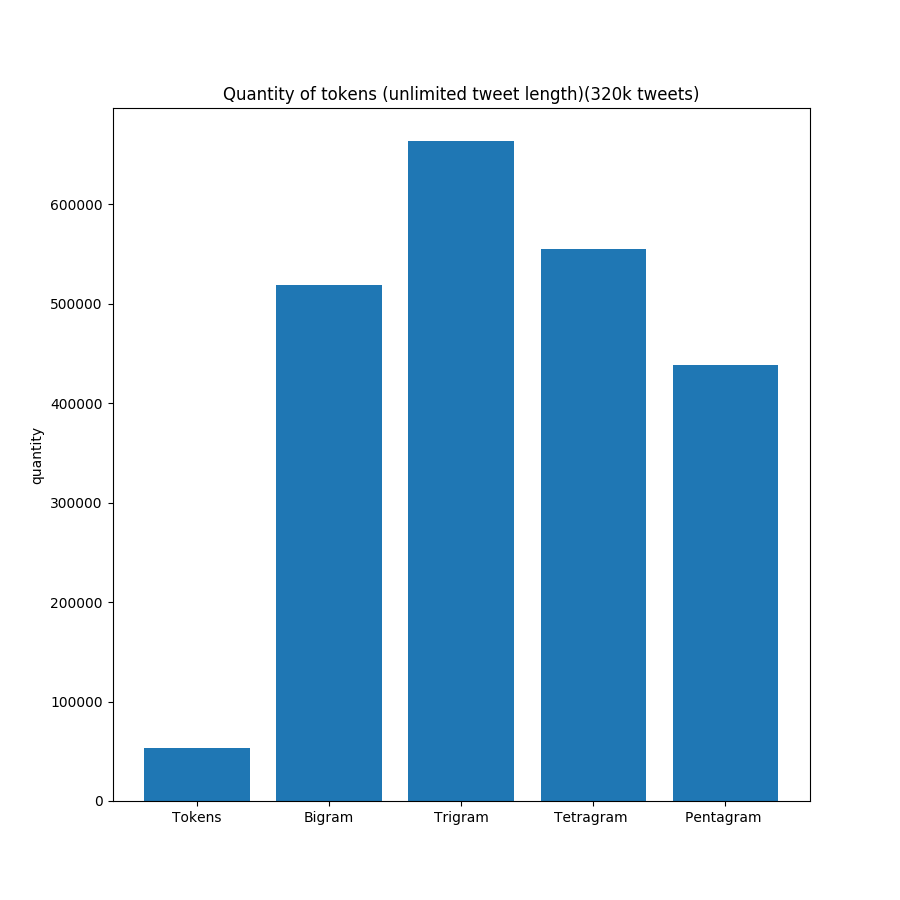

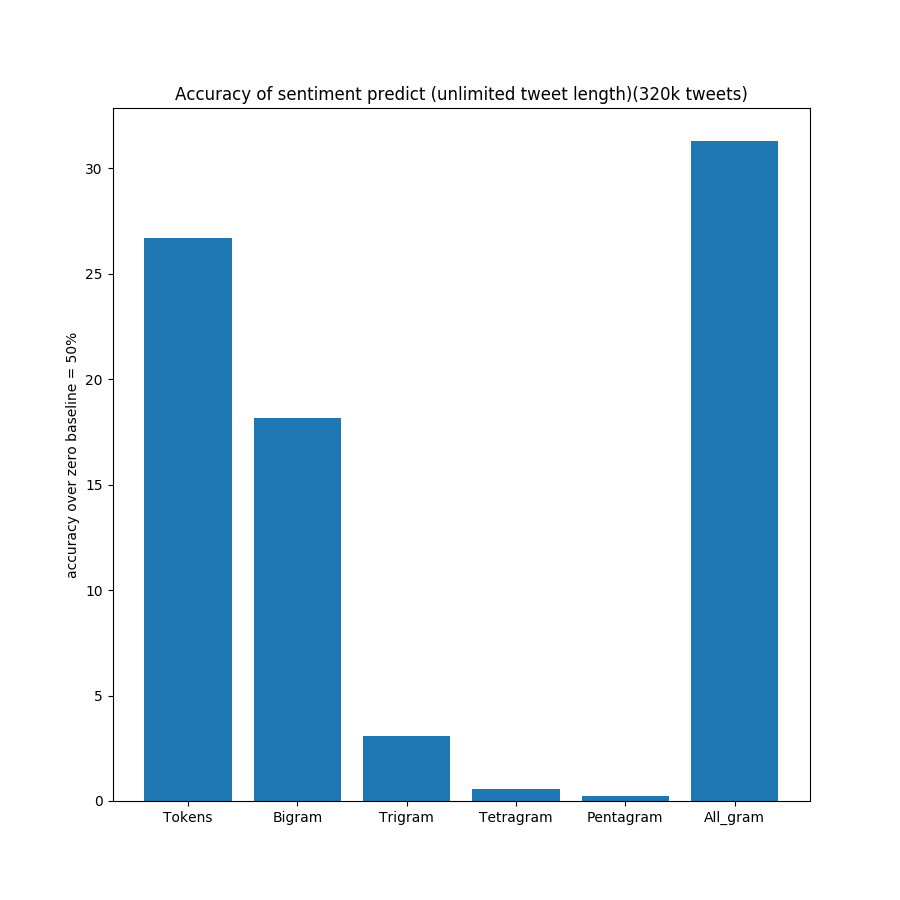

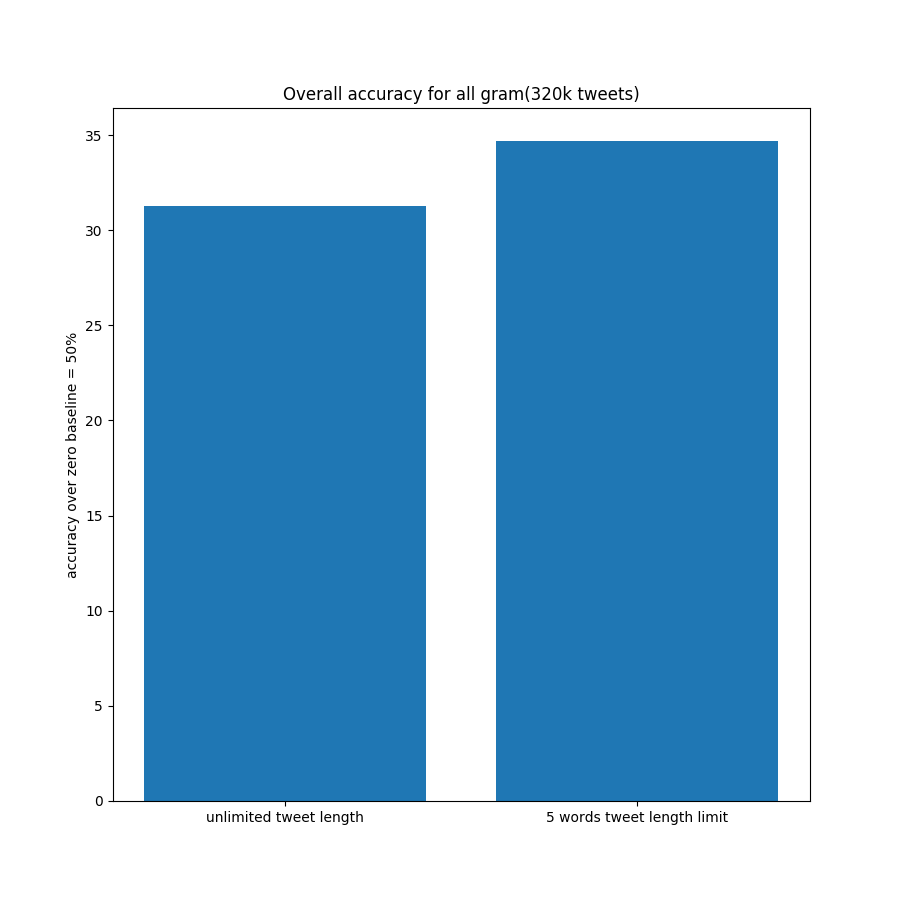

# Tweet Search of the analyzed user and use the previously trained model to assess sentiment of his tweets


## 1: Collect the required number of tweets of a specific user.
## 2: Cleaning users tweets
## 3: Predict clean tweets on our sentiment analysis model

In [9]:
import tweepy
import csv
import pandas as pd
from bs4 import BeautifulSoup
from nltk.tokenize import WordPunctTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
import re
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')


personal_csv_output = 'Amanda_Seyfried.csv'

consumer_key = 'NgbszsMy18esxzBRpnS6YJSg5'
consumer_secret = 'fUlGwElm7B7Q5UUl99TdnMewBA3xW9Cw5xmzBAq1xU9j5O6wUa'
access_key = '3847979172-1TNy6qbn1DvF2lHuUMpM86hAyRSxN8Uc9WpZzET'  # access_token
access_secret = 'ZCooGbFqAqxCyFtZGqMPczAhD6IkZW1TfT1hocKVPm8pV'

tok = WordPunctTokenizer()

pat1 = r'@[A-Za-z0-9_]+'
pat2 = r'https?://[^ ]+'
combined_pat = r'|'.join((pat1, pat2))
www_pat = r'www.[^ ]+'
negations_dic = {"isn't": "is not", "aren't": "are not", "wasn't": "was not", "weren't": "were not",
                 "haven't": "have not", "hasn't": "has not", "hadn't": "had not", "won't": "will not",
                 "wouldn't": "would not", "don't": "do not", "doesn't": "does not", "didn't": "did not",
                 "can't": "can not", "couldn't": "could not", "shouldn't": "should not", "mightn't": "might not",
                 "mustn't": "must not"}
neg_pattern = re.compile(r'\b(' + '|'.join(negations_dic.keys()) + r')\b')

def tweet_cleaner_updated(text, tweet_len=100):
    soup = BeautifulSoup(text, 'lxml')
    souped = soup.get_text()
    try:
        bom_removed = souped.decode("utf-8-sig").replace(u"\ufffd", "?")
    except:
        bom_removed = souped
    stripped = re.sub(combined_pat, '', bom_removed)
    stripped = re.sub(www_pat, '', stripped)
    lower_case = stripped.lower()
    neg_handled = neg_pattern.sub(lambda x: negations_dic[x.group()], lower_case)
    letters_only = re.sub("[^a-zA-Z]", " ", neg_handled)

    lema = WordNetLemmatizer()
    words = list()
    for word in tok.tokenize(letters_only):
        if len(word) > 1:
            word = lema.lemmatize(word)
            words.append(word)

    if len(words) <= tweet_len:
        return (" ".join(words)).strip()
    

def get_all_tweets(screen_name, tween_num=5):
    auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
    auth.set_access_token(access_key, access_secret)
    api = tweepy.API(auth)
    new_tweets = api.user_timeline(screen_name=screen_name, count=tween_num)
    return new_tweets


tweets = get_all_tweets("AmandaSeyfried", tween_num=100)

columns = ['Screen_Name', 'Time_Stamp', 'raw_tweet', 'text']
tweet_df = pd.DataFrame(columns=columns)
for tweet in tweets:
    lenDF = len(tweet_df)
    clr_tweet = tweet_cleaner_updated(tweet.text)
    tweet_df.loc[lenDF] = [tweet.user.screen_name, tweet.created_at, tweet.text, clr_tweet]
tweet_df.to_csv(personal_csv_output, encoding='utf-8', quoting=csv.QUOTE_ALL)

## Collect the required number of tweets of a specific user and cleaning users tweets

In [10]:
tweet_df.head(10)

,Screen_Name,Time_Stamp,raw_tweet,text
0,AmandaSeyfried,2018-10-16 19:28:06,Anyone else surprised that our president publi...,anyone else surprised that our president publi...
1,AmandaSeyfried,2018-09-16 00:05:18,Those texts are obviously lazy fakes. Sorry @J...,those text are obviously lazy fake sorry and j...
2,AmandaSeyfried,2018-09-15 18:44:35,https://t.co/7M4KgUu61X,
3,AmandaSeyfried,2018-09-13 23:04:13,RT @nokidhungry: We are SO EXCITED about this!...,rt we are so excited about this thanks for bei...
4,AmandaSeyfried,2018-09-04 03:45:43,The @BachelorABC should be voted in at this po...,the should be voted in at this point want more...
5,AmandaSeyfried,2018-08-28 02:20:42,YIKES @leodottavio #manyfails @BachParadise,yikes manyfails
6,AmandaSeyfried,2018-08-27 16:39:30,It’s true. If he talks shit about his ex-girlf...,it true if he talk shit about his ex girlfrien...
7,AmandaSeyfried,2018-06-20 03:09:42,What do we value anymore? Impossible to feel p...,what do we value anymore impossible to feel pa...
8,AmandaSeyfried,2018-06-08 19:17:02,One day the risk of reading a room will be gre...,one day the risk of reading room will be great...
9,AmandaSeyfried,2018-05-27 04:15:46,I wish Clay Henry lll could run for President ...,wish clay henry lll could run for president soon


## Predict clean tweets on our sentiment analysis model

In [11]:
import pickle
import numpy as np
import pandas as pd

predict_filename = 'Amanda_Seyfried.csv'
data_column_name = 'text'

def get_predict_df(filename, data_name, predict_model):
    predict_data_df = pd.read_csv(filename, index_col=0, encoding='latin1')
    predict_data_df['target'] = None
    for index in range(len(predict_data_df)):
        if predict_data_df[data_name][index] is np.nan:
            pass
        else:
            if int(predict_model.predict(list([predict_data_df[data_name][index]]))) == 1:
                predict_data_df['target'][index] = 'Postive'
            else:
                predict_data_df['target'][index] = 'Negative'
    return predict_data_df

saved_model = 'lemmatization_nolim_all.sav'
loaded_model = pickle.load(open(saved_model, 'rb'))
df = get_predict_df(predict_filename, data_column_name, loaded_model)
df.drop(['Screen_Name', 'Time_Stamp', 'text'], axis=1, inplace=True)
df.to_csv('Amanda_predict', encoding='latin1', index=False)
print(df)

                                            raw_tweet    target
0   Anyone else surprised that our president publi...  Negative
1   Those texts are obviously lazy fakes. Sorry @J...  Negative
2                             https://t.co/7M4KgUu61X      None
3   RT @nokidhungry: We are SO EXCITED about this!...  Negative
4   The @BachelorABC should be voted in at this po...   Postive
5         YIKES @leodottavio #manyfails @BachParadise  Negative
6   Itâs true. If he talks shit about his ex-gir...  Negative
7   What do we value anymore? Impossible to feel p...  Negative
8   One day the risk of reading a room will be gre...   Postive
9   I wish Clay Henry lll could run for President ...  Negative
10  @mcctheater whatever happened to âReasons To...  Negative
11  Why arenât these mentally ill kids not bombi...  Negative
12  The gun laws arenât changing and thereâs l...  Negative
13  #FirstReformedMovie: â...a story in which th...   Postive
14  @LifeInPiecesCBS: More @ThomasSadosk